# Binning of the scan diffraction data

# 0. Preamble

In [1]:
%matplotlib nbagg

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt

In [3]:
sys.path.insert(0, '/data/users/vadim/libertem/src/')

In [4]:
import libertem.api as lt

# 1. Binning in the scan space

In [34]:
path_to_data = '/data/users/vadim/2019-02-21_AIST_switching_Sebastian_w3b8c3/34/'
path_to_data = "/home/clausen/Data/Merlin/"
binning = 2

In [6]:
ctx = lt.Context()

In [37]:
ds = ctx.load('mib',
              path=path_to_data + '02_ms1_8p8G.hdr',
              tileshape=(1, 20, 256, 256))

In [ ]:
scan_size = tuple(ds.shape)[:2]  # should be (186, 357) for this dataset

<IPython.core.display.Javascript object>


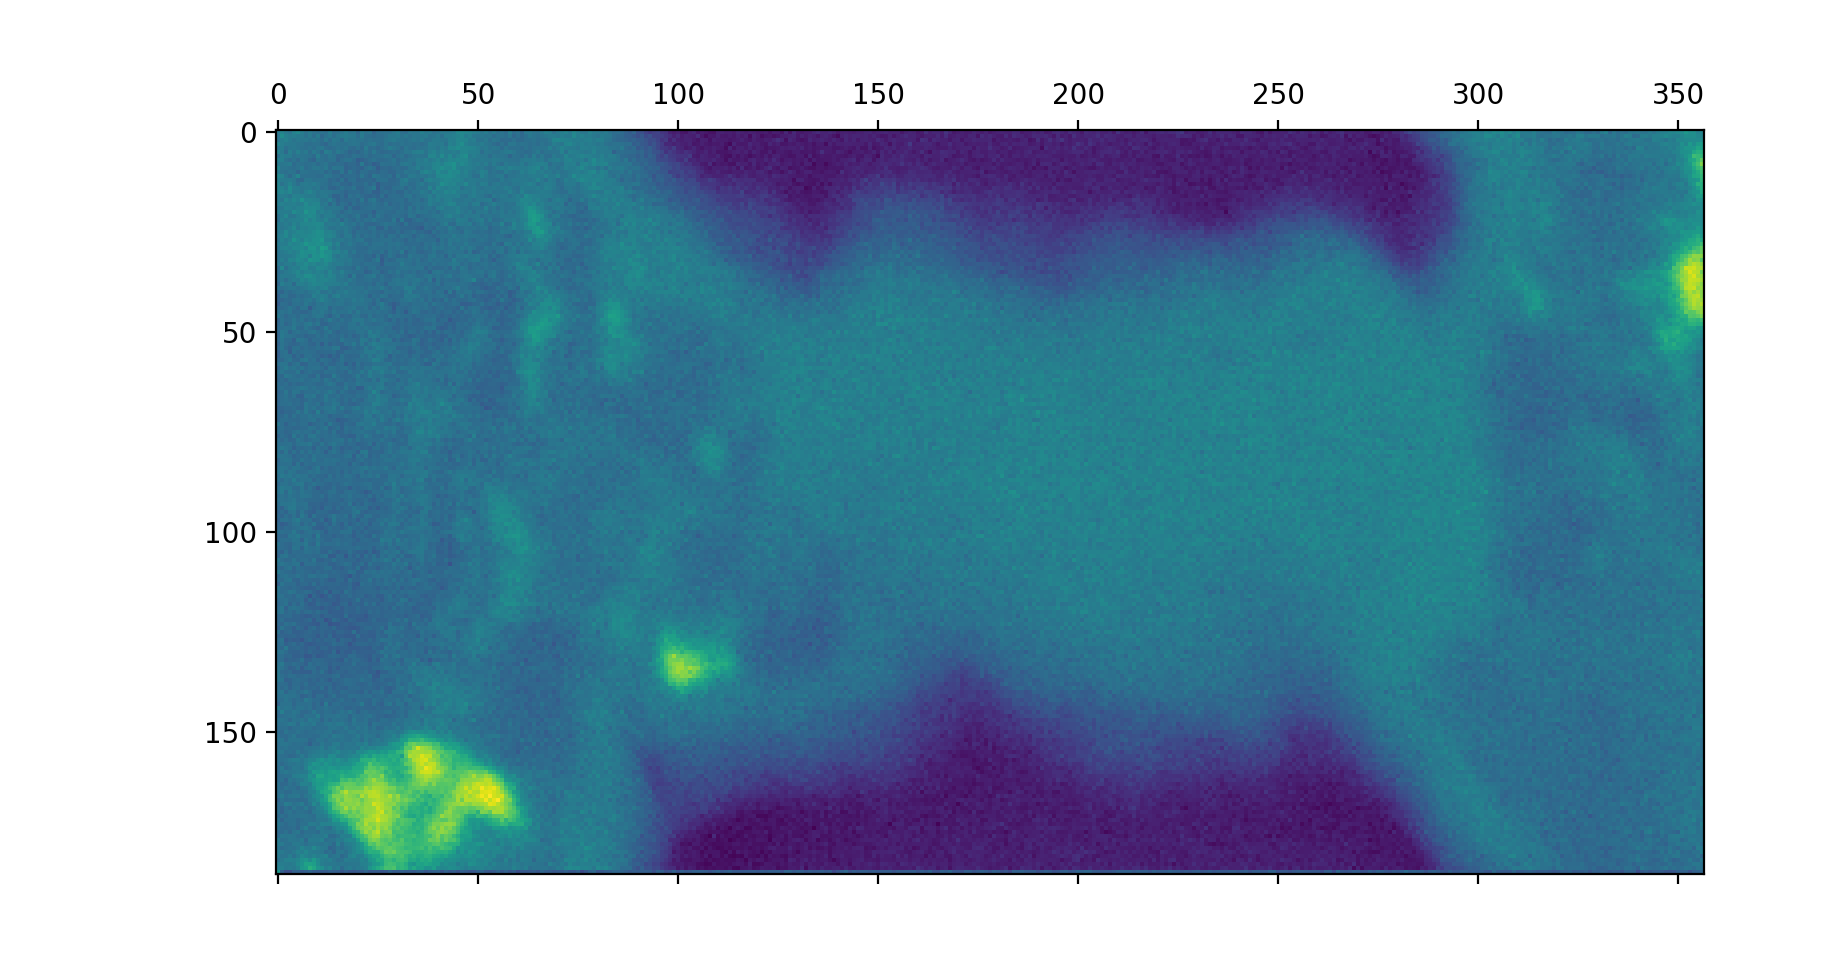

In [19]:
job = ctx.create_ring_analysis(ds, cx=126, cy=128, ri=12, ro=113)
df0 = ctx.run(job)

plt.matshow(df0.intensity.raw_data)

In [20]:
frame_sx, frame_sy = ds.shape.to_tuple()[-2:]
shape_out = (scan_size[0]//binning * scan_size[1]//binning, frame_sx, frame_sy)

# dtype_out = ds.dtype
dtype_out = 'float32'

result = np.memmap(path_to_data+'02_ms1_8p8G_bin.raw', dtype=dtype_out, mode='w+', shape=shape_out)

In [21]:
def get_frame_gid(frame_tid, tile, scan_size):
    """
    frame_tid : int
        index of the frame relative to the tile
    tile : DataTile
    scan_size : (int, int)
    """
    return tile.tile_slice.origin[0] + frame_tid

def get_frame_dest_id(fx, fy, binning, scan_size):
    return np.ravel_multi_index((fx//binning, fy//binning), (scan_size[0]//binning, scan_size[1]//binning))

In [22]:
# mode = 'crop'
for partition in ds.get_partitions():
    for i, tile in enumerate(partition.get_tiles(full_frames=True)):
        data = tile.data
        for frame_tid, frame in enumerate(data):
            frame_gid = get_frame_gid(frame_tid, tile, scan_size)
            fx, fy = np.unravel_index(frame_gid, scan_size)
            if (fx+1)<= scan_size[0]//binning*binning\
                and (fy+1) <=scan_size[1]//binning*binning:  # cropping the data to integer size
                
                frame_dest_id = get_frame_dest_id(fx, fy, binning, scan_size)
                result[frame_dest_id] += frame

<IPython.core.display.Javascript object>


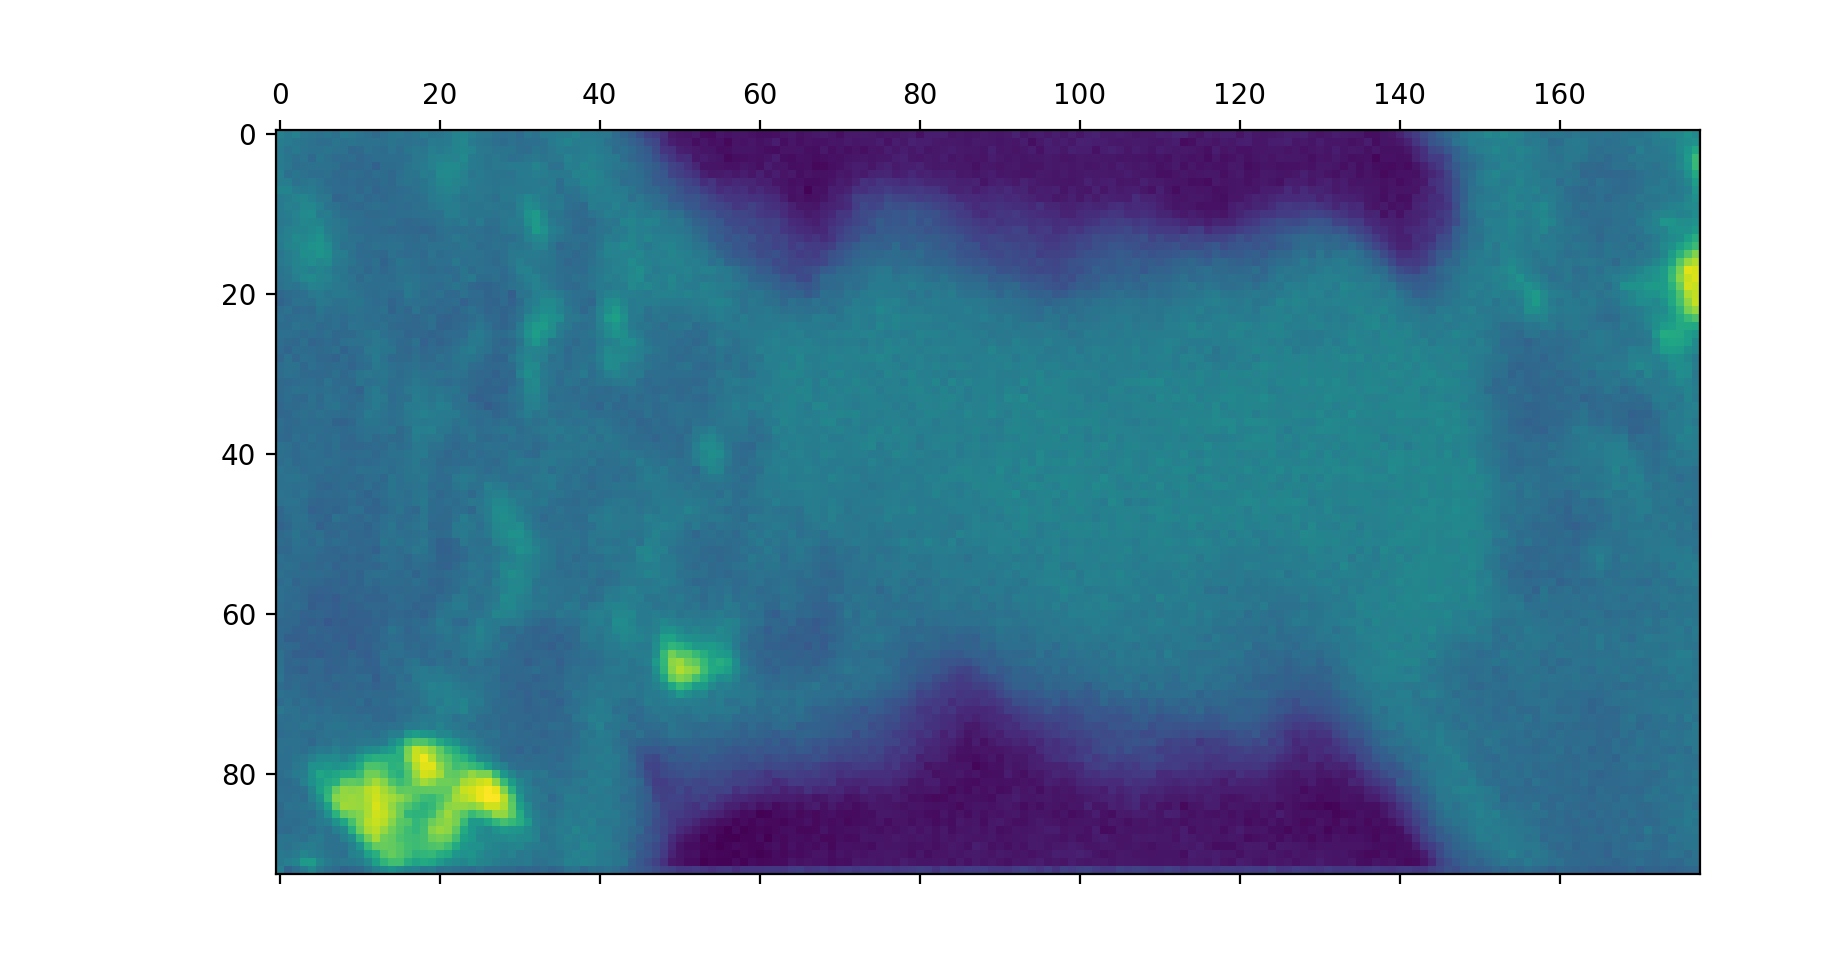

In [23]:
frame_shape = (frame_sx, frame_sy)
scan_shape_bin = (scan_size[0]//binning, scan_size[1]//binning)
ds = ctx.load('raw',
              path=path_to_data+'02_ms1_8p8G_bin.raw',
              scan_size=scan_shape_bin,
              detector_size_raw=frame_shape,
              crop_detector_to=frame_shape,
              dtype=dtype_out,
              tileshape=(1, 8, 128, 128))

#(scan_size[0], scan_size[1], frame_sx, frame_sy) = ds.shape

job = ctx.create_ring_analysis(ds, cx=126, cy=128, ri=12, ro=113)

df1 = ctx.run(job)
plt.matshow(df1.intensity.raw_data)

In [24]:
def bin_array2d(a, binning):
    sx, sy = a.shape
    sxc = sx // binning * binning
    syc = sy // binning * binning
    #crop:
    ac = a[:sxc, :syc]
    return ac.reshape(ac.shape[0]//binning, binning, ac.shape[1]//binning, binning).sum(3).sum(1)

<IPython.core.display.Javascript object>


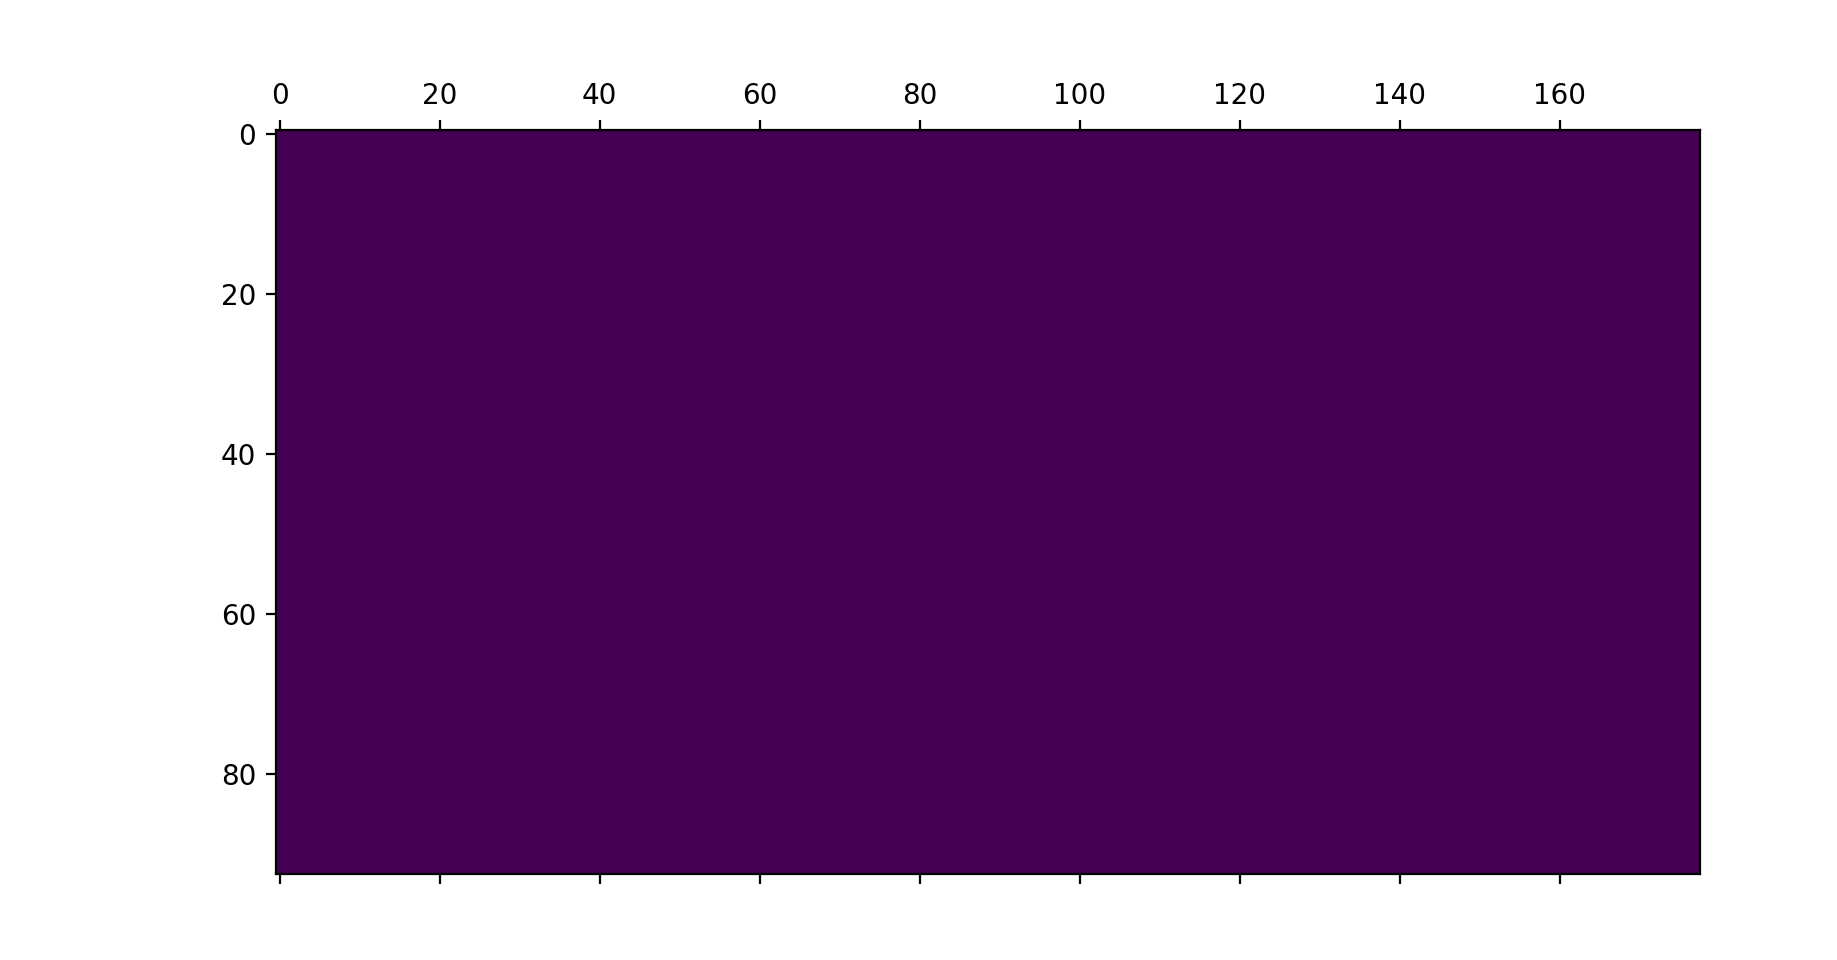

In [25]:
df0_bin = bin_array2d(df0.intensity.raw_data, binning)
#bf0_bin[50, 50] *= 0.1 

plt.matshow(df1.intensity.raw_data-df0_bin)

In [26]:
np.any(df1.intensity.raw_data-df0_bin)

False

Surprisingly binning data before and after calculating DF results gives absolutely identical results.

In [27]:
print(i)
print(frame_tid)
print(frame_gid)
print(scan_size[0]*scan_size[1])
print(frame_dest_id)
print(scan_size[0]//binning * scan_size[1]//binning)
print(fx, fy)
print(scan_size[0]//binning, scan_size[1]//binning)

0
101
66401
66402
16553
16600
185 356
93 178


# 2. Binning in the diffraction space 

In [28]:
shape_out = (scan_size[0] * scan_size[1], frame_sx // binning, frame_sy // binning)

ds = ctx.load('mib',
              path=path_to_data + '02_ms1_8p8G.mib',
              scan_size=scan_size,
              tileshape=(1, 20, 256, 256))

result = np.memmap(path_to_data+'02_ms1_8p8G_bin-d.raw', dtype=dtype_out, mode='w+', shape=shape_out)

In [30]:
for partition in ds.get_partitions():
    for i, tile in enumerate(partition.get_tiles(full_frames=True)):
        data = tile.data
        for frame_tid, frame in enumerate(data):
            frame_gid = get_frame_gid(frame_tid, tile, scan_size)
            result[frame_gid] = bin_array2d(frame, binning)

<IPython.core.display.Javascript object>


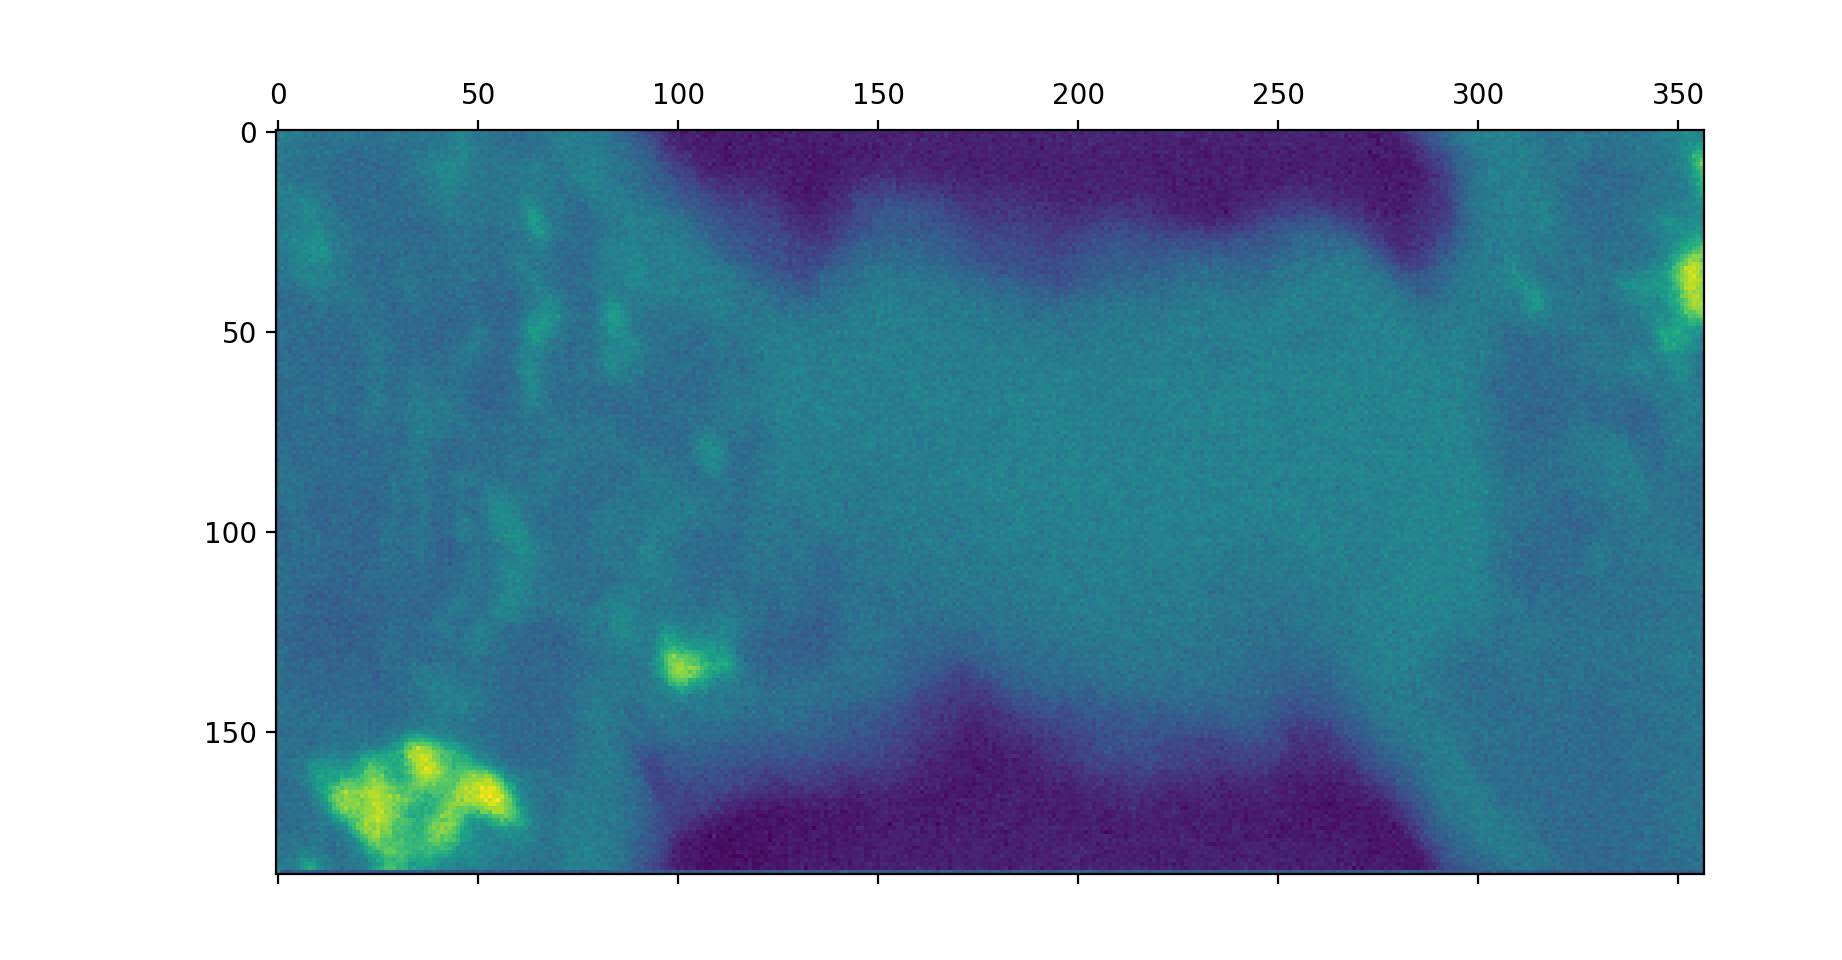

In [31]:
frame_shape_bin = tuple(fs // binning for fs in frame_shape)
ds = ctx.load('raw',
              path=path_to_data+'02_ms1_8p8G_bin-d.raw',
              scan_size=scan_size,
              detector_size_raw=frame_shape_bin,
              crop_detector_to=frame_shape_bin,
              dtype=dtype_out,
              tileshape=(1, 8, 128, 128))

job = ctx.create_ring_analysis(ds, cx=126//binning, cy=128//binning, ri=12//binning, ro=113//binning)

df4 = ctx.run(job)
plt.matshow(df4.intensity.raw_data)

<IPython.core.display.Javascript object>


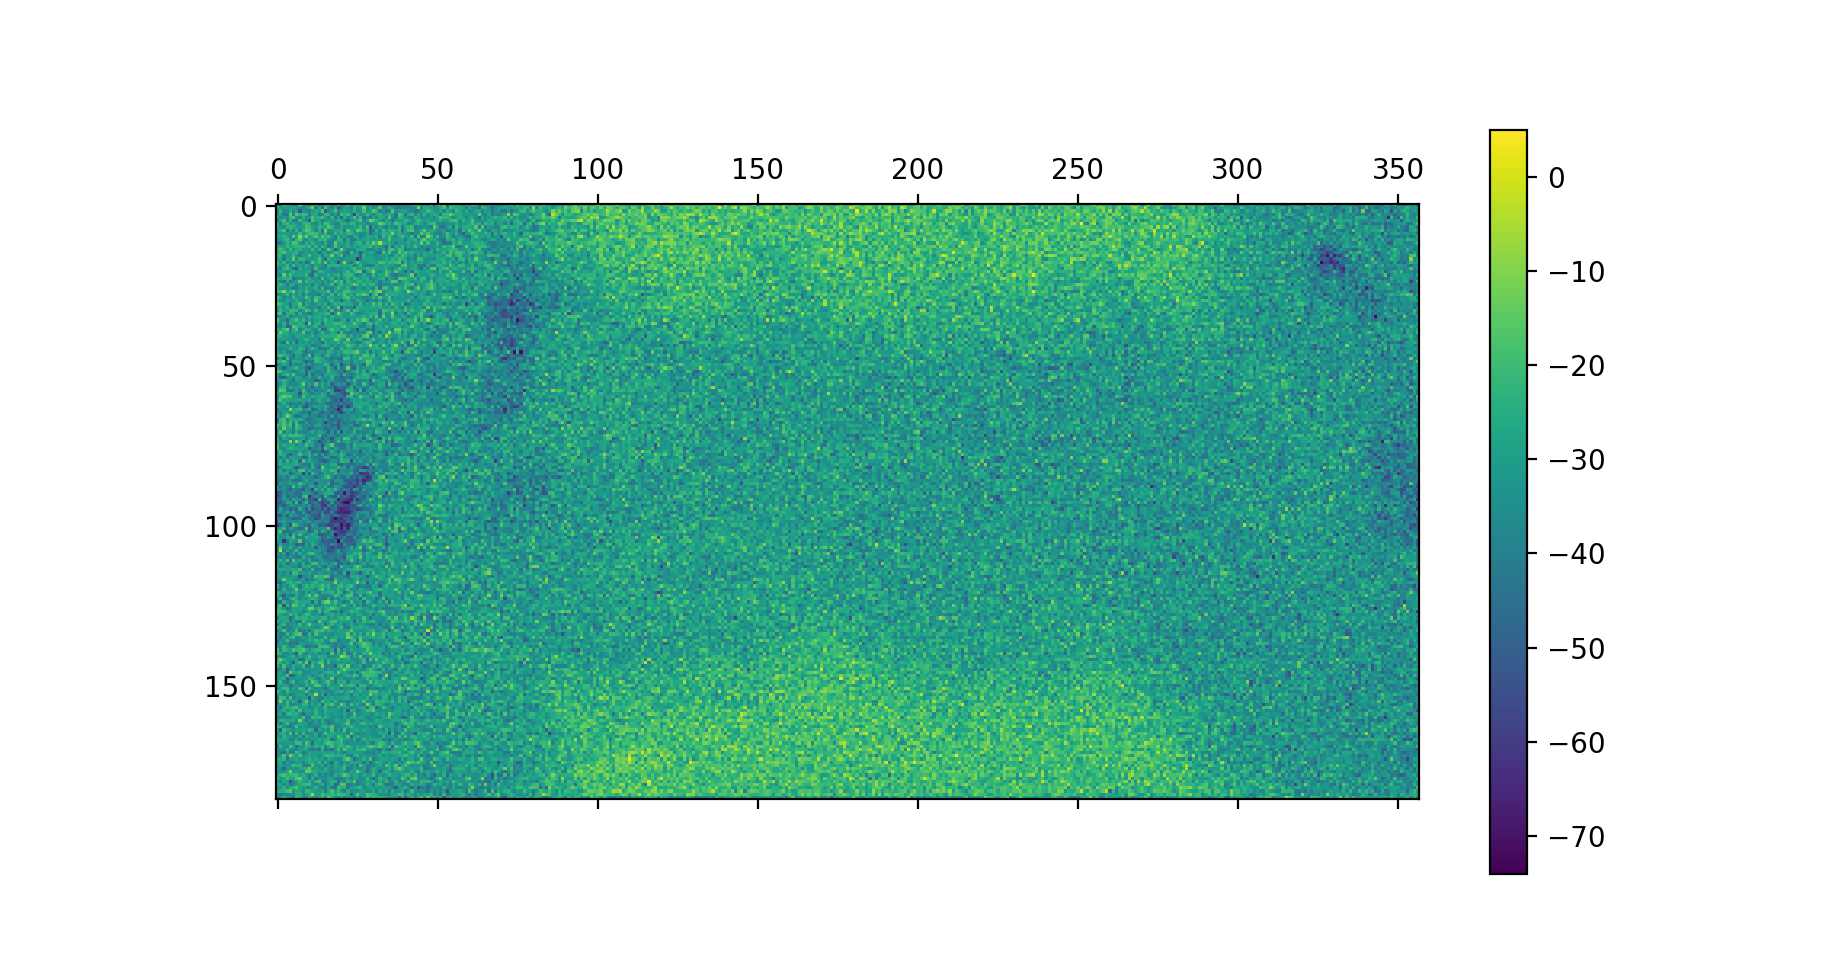

In [32]:
diff = df4.intensity.raw_data - df0.intensity.raw_data
plt.matshow(diff)
plt.colorbar()

In [33]:
print((diff[11, 30], diff[57, 71], diff[100, 100]))
print(df0.intensity.raw_data.mean())
print(df0.intensity.raw_data.std())
print(diff.mean())
print(diff.std())

(-33.0, -45.0, -33.0)
3992.652
376.29886
-29.374582
9.146259


Difference is reasonable especially taking into account that the DF mask was not re-centered properly for the dataset binned in diffraction space